In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-heat-circumference/test_set/245_HC.png
/kaggle/input/fetal-heat-circumference/test_set/073_HC.png
/kaggle/input/fetal-heat-circumference/test_set/137_HC.png
/kaggle/input/fetal-heat-circumference/test_set/094_HC.png
/kaggle/input/fetal-heat-circumference/test_set/001_HC.png
/kaggle/input/fetal-heat-circumference/test_set/034_HC.png
/kaggle/input/fetal-heat-circumference/test_set/213_HC.png
/kaggle/input/fetal-heat-circumference/test_set/253_HC.png
/kaggle/input/fetal-heat-circumference/test_set/221_HC.png
/kaggle/input/fetal-heat-circumference/test_set/119_HC.png
/kaggle/input/fetal-heat-circumference/test_set/157_HC.png
/kaggle/input/fetal-heat-circumference/test_set/120_HC.png
/kaggle/input/fetal-heat-circumference/test_set/123_HC.png
/kaggle/input/fetal-heat-circumference/test_set/014_HC.png
/kaggle/input/fetal-heat-circumference/test_set/329_HC.png
/kaggle/input/fetal-heat-circumference/test_set/288_HC.png
/kaggle/input/fetal-heat-circumference/test_set/097_HC.p

In [2]:
import os

input_dir = "../input/fetal-heat-circumference/fetal training set/"
target_dir = "../input/fetal-heat-circumference/fetal head annotation/"
img_size = (160, 160)
num_classes = 2
batch_size = 3

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 125
../input/fetal-heat-circumference/fetal training set/000_HC.png | ../input/fetal-heat-circumference/fetal head annotation/000_HC_Annotation.png
../input/fetal-heat-circumference/fetal training set/001_HC.png | ../input/fetal-heat-circumference/fetal head annotation/001_HC_Annotation.png
../input/fetal-heat-circumference/fetal training set/002_HC.png | ../input/fetal-heat-circumference/fetal head annotation/002_HC_Annotation.png
../input/fetal-heat-circumference/fetal training set/003_HC.png | ../input/fetal-heat-circumference/fetal head annotation/003_HC_Annotation.png
../input/fetal-heat-circumference/fetal training set/004_HC.png | ../input/fetal-heat-circumference/fetal head annotation/004_HC_Annotation.png
../input/fetal-heat-circumference/fetal training set/005_HC.png | ../input/fetal-heat-circumference/fetal head annotation/005_HC_Annotation.png
../input/fetal-heat-circumference/fetal training set/006_HC.png | ../input/fetal-heat-circumference/fetal head an

In [4]:
input_img_paths[9]

'../input/fetal-heat-circumference/fetal training set/009_HC.png'

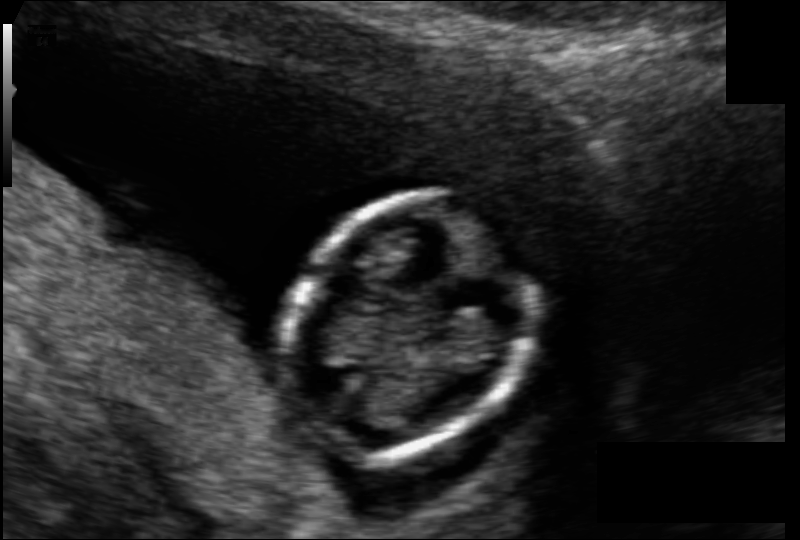

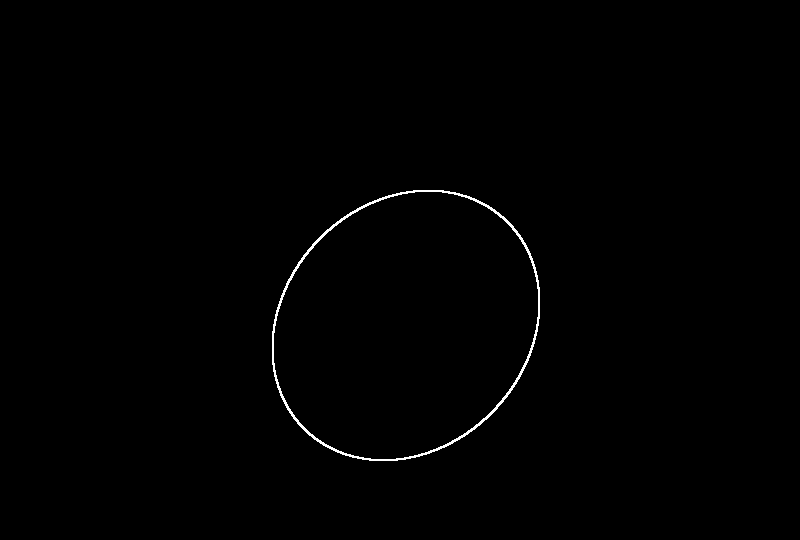

In [39]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x/255, y/255  # normalization

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
import random

# Split our img paths into a training and a validation set
val_samples = 26
random.Random(100).shuffle(input_img_paths)
random.Random(100).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [95]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
history=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
33/33 [==============================] - 6s 59ms/step - loss: 0.0585 - accuracy: 0.0121 - val_loss: 0.0456 - val_accuracy: 0.0000e+00


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
33/33 [==============================] - 2s 68ms/step - loss: 0.0234 - accuracy: 2.5844e-04 - val_loss: 0.0399 - val_accuracy: 0.0000e+00
Epoch 3/50
33/33 [==============================] - 1s 43ms/step - loss: 0.0236 - accuracy: 3.0895e-04 - val_loss: 0.0354 - val_accuracy: 0.0000e+00
Epoch 4/50
33/33 [==============================] - 1s 42ms/step - loss: 0.0232 - accuracy: 2.6160e-04 - val_loss: 0.0406 - val_accuracy: 0.0000e+00
Epoch 5/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0226 - accuracy: 4.9755e-04 - val_loss: 0.0376 - val_accuracy: 0.0000e+00
Epoch 6/50
33/33 [==============================] - 1s 40ms/step - loss: 0.0226 - accuracy: 5.2083e-04 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 7/50
33/33 [==============================] - 1s 40ms/step - loss: 0.0208 - accuracy: 4.0365e-04 - val_loss: 0.0379 - val_accuracy: 1.6276e-06
Epoch 8/50
33/33 [==============================] - 1s 43ms/step - loss: 0.0202 - accuracy: 5.8673e-04 - v

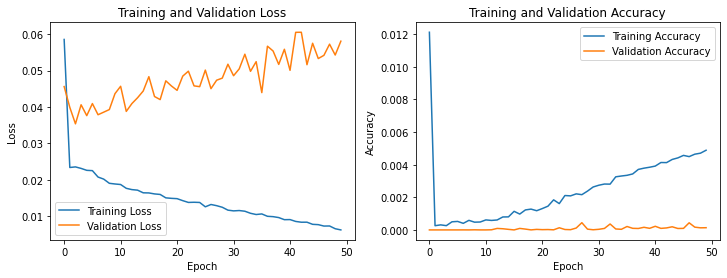

In [96]:
# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

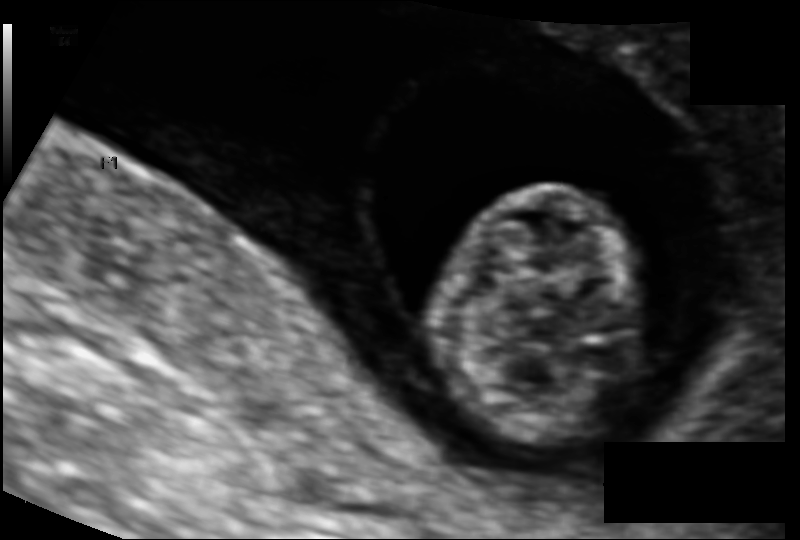

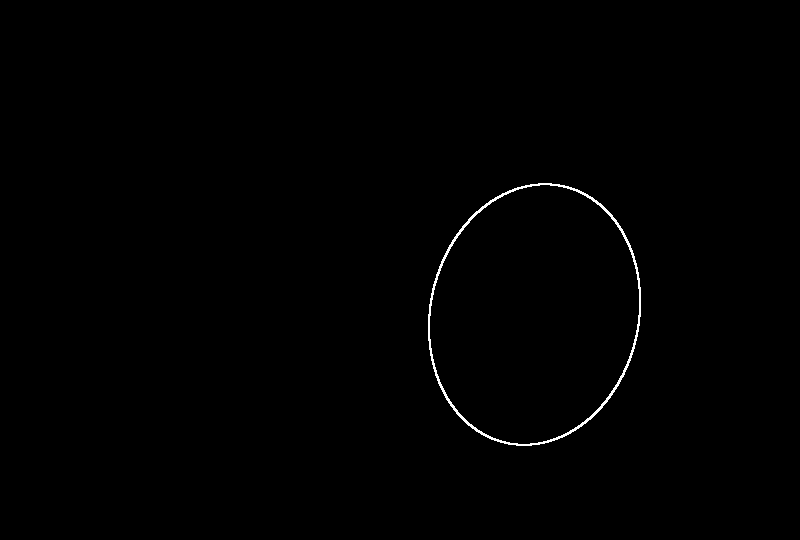

25600


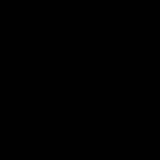

In [94]:
val_gen = OxfordPets(3, img_size, val_input_img_paths, val_target_img_paths)
val_preds = (model.predict(val_gen))


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    print(mask.sum())
    imgContrast = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(imgContrast)


# Display results for validation image #10
i = 20#12

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i) 

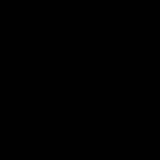

In [91]:
display_mask(i)

In [84]:
def get_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    
    return mask

In [90]:
160*160

25600

In [89]:
maski =get_mask(i)
print(maski.__class__)
print(maski.shape)
print(maski.sum())

<class 'numpy.ndarray'>
(160, 160)
25600


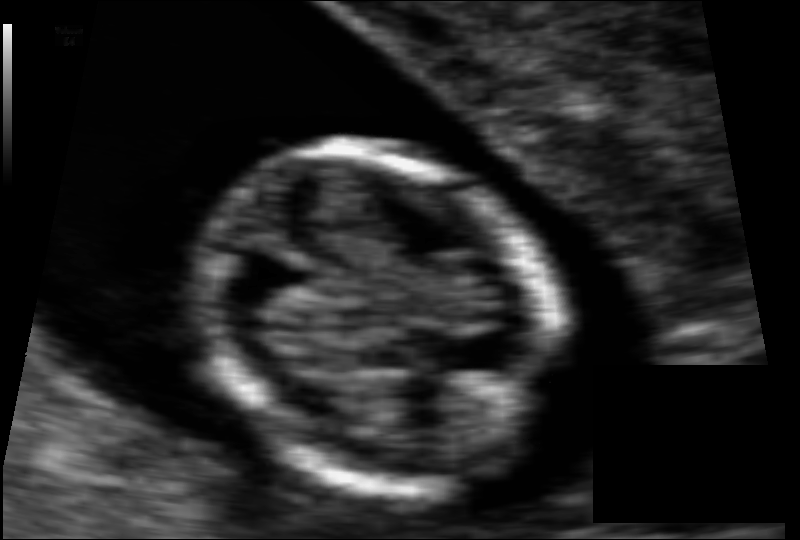

In [54]:
imgRead = Image(filename=val_input_img_paths[i])
display(imgRead )

In [55]:
imgRead.__class__

IPython.core.display.Image

In [57]:
# Create a PIL Image from the image data
#pil_image = PILImage.open(io.BytesIO(imgRead))

In [59]:
from PIL import Image as PILImage

In [66]:
import io
import cv2

In [65]:
fname=val_input_img_paths[i]
fname

'../input/fetal-heat-circumference/fetal training set/043_HC.png'

In [68]:
imagePng = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
print(imagePng.shape)

(540, 800)


In [70]:
imagePng.__class__

numpy.ndarray

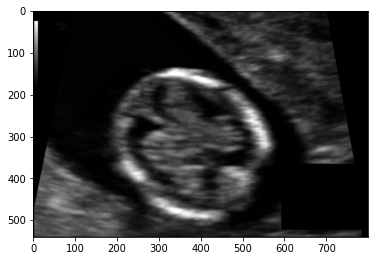

In [73]:
plt.figure(figsize=(6,8))
plt.imshow(imagePng,cmap='gray')

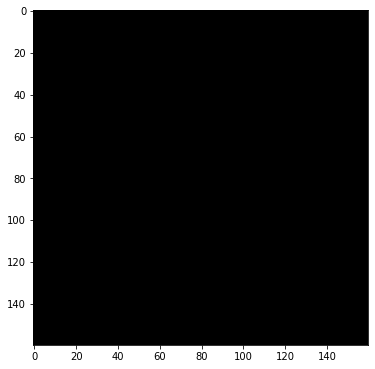

In [87]:
plt.figure(figsize=(6,8))
plt.imshow(maski>0,cmap='gray')

In [63]:
#pil_image = PILImage.open(io.BytesIO(imgRead))

In [64]:
#numpy_img = np.array(bytearray(imgRead))
#print(numpy_img.shape)
#plt.figure(figsize=(4,6))
#plt.imshow(numpy_img,cmap='gray')

In [31]:
val_gen = OxfordPets(3, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
val_gen.__getitem__

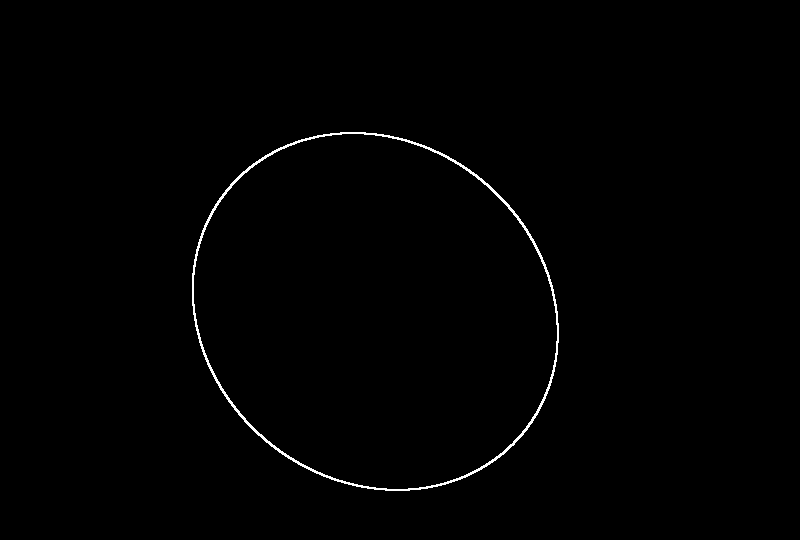

<class 'PIL.Image.Image'>


In [37]:
 imgLoad = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
 display( imgLoad ) 
 print(imgLoad.__class__)
 
 numpy_img = np.array(imgLoad)

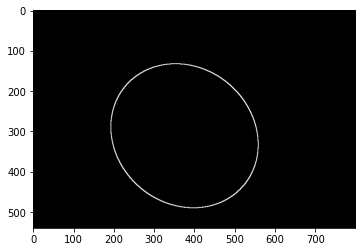

In [36]:
plt.figure()
plt.imshow(numpy_img,cmap='gray')

In [15]:
img.__class__

PIL.Image.Image

In [16]:
mask = np.argmax(val_preds[i], axis=-1)
mask = np.expand_dims(mask, axis=-1)
imgMask = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
imgMask.__class__

PIL.Image.Image

In [17]:
#from PIL import Image, ImageDraw

In [24]:
def showImageAndMask(original_image,mask_image):
    
    if original_image.size != mask_image.size:
       mask_image = mask_image.resize(original_image.size)

    # Create a composite image
    composite_image = Image.new("RGBA", original_image.size)
    composite_image.paste(original_image, (0, 0))

    # Overlay the mask image onto the composite image
    composite_image.paste(mask_image, (0, 0), mask_image)

    # Display or save the composite image
    display(composite_image)  # Display the image

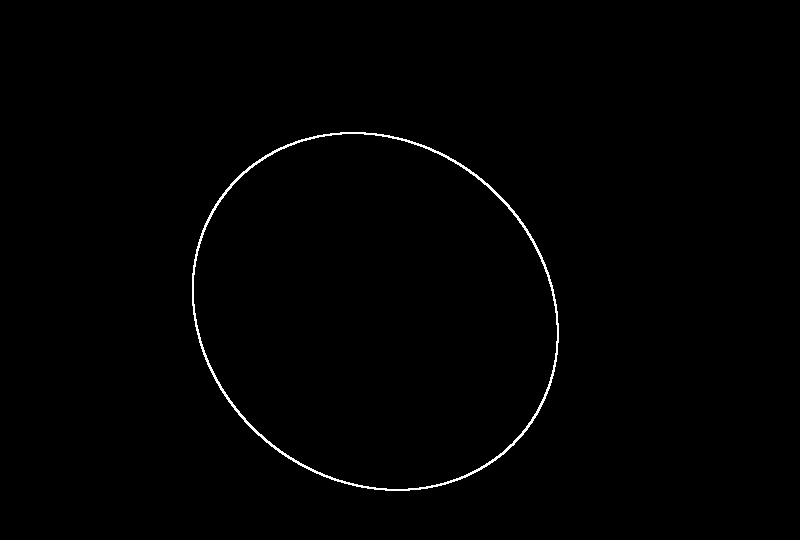

In [25]:
showImageAndMask(img,imgMask)

In [13]:
from matplotlib import pyplot as plt

In [30]:
imgR = Image(filename=val_input_img_paths[i])


TypeError: 'module' object is not callable

In [34]:
#numpy_img = np.array(Image(filename=val_input_img_paths[i]))
#numpy_mask = np.array(imgMask)

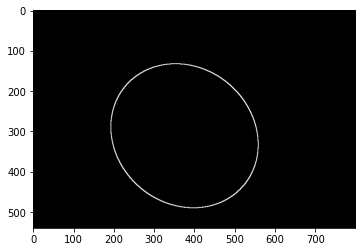

In [27]:
plt.imshow(numpy_img ,cmap='gray')

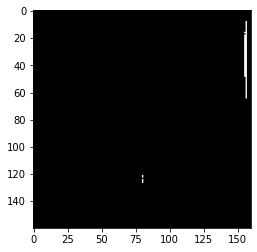

In [14]:
preds_test_thresh = (val_preds >= .5).astype(np.uint8)
# Display a thresholded mask

test_img = preds_test_thresh[0, :, :, 0]

plt.imshow(test_img, cmap='gray')